In [2]:
## Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict


## xgboost model
import pickle
import xgboost as xgb
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

# Dataset
from aif360.datasets import BinaryLabelDataset

# Dataset repo from UCI
from ucimlrepo import fetch_ucirepo 
from aif360.datasets import AdultDataset, StandardDataset

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing import LFR
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import tensorflow session
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [3]:


def test(dataset, model, thresh_arr, unprivileged_groups, privileged_groups):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = 1
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        ## Balanced Accuracy (TPR + TNR)/2
        metric_arrs['acc'].append(metric.accuracy())
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['threshold_value'].append(thresh)
        ## calculate F1 score 
        metric_arrs['F1_score'].append(2 *((metric.precision()*metric.recall())/(metric.precision()+metric.recall())))
        metric_arrs['false_omission_rate'].append(metric.false_omission_rate())
        metric_arrs['false_omission_rate_ratio'].append(metric.false_omission_rate_ratio())
        ## Average Odds Difference (average difference between TPR and TNR of groups)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        ## Whether ratio of favorable outcome is consistent
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        ## Difference in probability of receiving favorable outcome
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        ## Whether individual have equal chances of receiving positive outcome when they should
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        ## Measure inequality of model errors across group
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [4]:
def plot_results(x, x_name, y_left, y_left_name, y_right, y_right_name, title = None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    if title is not None:
        ax1.set_title(title)

## Comparison of the Four Pre-Processing Methods in AIF360

#### This report is performed on the adult dataset on race as a protected attribute. Same analysis can be performed for sex, and both race and sex as protected attributes. 
#### Here we compare as many methods as we can from AIF360 to get a comprehensive evaluation of how well the model performs on the Adult dataset.


In [4]:
# fetch dataset 
adult = AdultDataset()  

In [5]:
# Convert Adult dataset to a binary dataset
## Read any data for testing into a dataframe and feed into binary label dataset
data = adult.convert_to_dataframe()[0]

In [6]:
# Initiate the binary label dataset - AIF360 convention
binary_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df = data,
    label_names = ["income-per-year"],
    protected_attribute_names = ["race"],
)

# Split data into training and testing sets
data_train, data_test = binary_data.split([0.7], shuffle=True)

unprivileged_groups=[{ "race":0}]
privileged_groups=[{ "race":1}]


# For both race and sex 
# # Set unpriviledged groups and priviledged groups
# unprivileged_groups=[{"race":0, "sex":0}]
# privileged_groups=[{"race":1, "sex":1}]

## for sex set unpriviledged groups and priviledged groups

# unprivileged_groups=[{ "sex":0}]
# privileged_groups=[{ "sex":1}]


### Make base model to assess Disparate Impact

In [7]:
X_train = data_train.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_train = data_train.convert_to_dataframe()[0]["income-per-year"]
X_test = data_test.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_test = data_test.convert_to_dataframe()[0]["income-per-year"]

## Build model 
xgb_model = xgb.XGBClassifier(random_state = 2023)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

## Conduct Random Search
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter = 10, 
                                   cv = 5, 
                                   scoring="roc_auc",
                                   random_state=2023)
random_search.fit(X_train, y_train)
best_xgb_original = random_search.best_estimator_
thresh_arr = np.linspace(0.01, 0.5, 50)



In [8]:
## Generate Metrics
val_metrics = test(dataset=data_test,
                   model=best_xgb_original,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)

# lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

original_metrics = {
    "name":"Vanilla XGBoost",
    "balanced accuracy":val_metrics["bal_acc"][lr_orig_best_ind],
    "disparate impact":val_metrics["disp_imp"][lr_orig_best_ind],
    "accuracy":val_metrics["acc"][lr_orig_best_ind],
    "F1_score":val_metrics["F1_score"][lr_orig_best_ind],
    "false_omission_rate":val_metrics["false_omission_rate"][lr_orig_best_ind],
    "false_omission_rate_ratio":val_metrics["false_omission_rate_ratio"][lr_orig_best_ind],
    "threshold_value": val_metrics["threshold_value"][lr_orig_best_ind],
}
print(original_metrics)

{'name': 'Vanilla XGBoost', 'balanced accuracy': 0.8445971910713803, 'disparate impact': 0.5242813547920613, 'accuracy': 0.834303825458834, 'F1_score': 0.7159464240586304, 'false_omission_rate': 0.049720044792833144, 'false_omission_rate_ratio': 0.5952819332566168, 'threshold_value': 0.27}


### Use Reweighting Scheme


In [9]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(data_train)
data_train_reweighed = RW.transform(data_train)

X_train = data_train_reweighed.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_train = data_train_reweighed.convert_to_dataframe()[0]["income-per-year"]
X_test = data_train_reweighed.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_test = data_train_reweighed.convert_to_dataframe()[0]["income-per-year"]

## Build model 
xgb_model = xgb.XGBClassifier()
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

## Conduct Random Search
fit_param = {"sample_weight":data_train_reweighed.instance_weights}
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter = 10, 
                                   cv = 5, 
                                   scoring="roc_auc", 
                                   random_state=2023)
random_search.fit(X_train, y_train, **fit_param)
best_xgb_reweighed = random_search.best_estimator_
thresh_arr = np.linspace(0.01, 0.5, 50)



In [10]:
## Generate Metrics
val_metrics_reweigh = test(dataset=data_test,
                   #### Change Model ####
                   model=best_xgb_reweighed,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)
lr_reweight_best_ind = np.argmax(val_metrics_reweigh['bal_acc'])
#### Change Metric name ####
reweight_metrics = {
    #### Change Name ####
    "name":"XGBoost after Reweighting",
    "balanced accuracy":val_metrics_reweigh["bal_acc"][lr_reweight_best_ind],
    "disparate impact":val_metrics_reweigh["disp_imp"][lr_reweight_best_ind],
    "accuracy":val_metrics_reweigh["acc"][lr_reweight_best_ind],
    "F1_score":val_metrics_reweigh["F1_score"][lr_reweight_best_ind],
    "false_omission_rate":val_metrics_reweigh["false_omission_rate"][lr_reweight_best_ind],
    "false_omission_rate_ratio":val_metrics_reweigh["false_omission_rate_ratio"][lr_reweight_best_ind],
    "threshold_value": val_metrics_reweigh["threshold_value"][lr_reweight_best_ind],
}
print(reweight_metrics)

{'name': 'XGBoost after Reweighting', 'balanced accuracy': 0.8435905579808975, 'disparate impact': 0.6423257025790379, 'accuracy': 0.8245743347829292, 'F1_score': 0.7079754601226994, 'false_omission_rate': 0.04508856682769726, 'false_omission_rate_ratio': 0.4926419632301985, 'threshold_value': 0.24000000000000002}


### Preprocessing: LFR

Use Learned Feature Representation to create new fairer feature independent of protected variables.

In [11]:
lfr = LFR(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
lfr.fit(data_train)
data_train_lfr = lfr.transform(data_train)

X_train = data_train_lfr.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_train = data_train_lfr.convert_to_dataframe()[0]["income-per-year"]
X_test = data_train_lfr.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_test = data_train_lfr.convert_to_dataframe()[0]["income-per-year"]

## Build model 
xgb_model = xgb.XGBClassifier(random_state = 2023)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

## Conduct Random Search
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter = 10, 
                                   cv = 5, 
                                   scoring="roc_auc")
random_search.fit(X_train, y_train)
best_xgb_lfr = random_search.best_estimator_
thresh_arr = np.linspace(0.01, 0.5, 50)



In [12]:
## Generate Metrics
val_metrics_lfr = test(dataset=data_test,
                   #### Change Model ####
                   model=best_xgb_lfr,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)
lr_lfr_best_ind = np.argmax(val_metrics_lfr['bal_acc'])
#### Change Metric name ####
lfr_metrics = {
    #### Change Name ####
    "name":"XGBoost with Learning Fair Representations",
    "balanced accuracy":val_metrics_lfr["bal_acc"][lr_lfr_best_ind],
    "disparate impact":val_metrics_lfr["disp_imp"][lr_lfr_best_ind],
    "accuracy":val_metrics_lfr["acc"][lr_lfr_best_ind],
    "F1_score":val_metrics_lfr["F1_score"][lr_lfr_best_ind],
    "false_omission_rate":val_metrics_lfr["false_omission_rate"][lr_lfr_best_ind],
    "false_omission_rate_ratio":val_metrics_lfr["false_omission_rate_ratio"][lr_lfr_best_ind],
    "threshold_value": val_metrics_lfr["threshold_value"][lr_lfr_best_ind]
}


print(lfr_metrics)

/opt/miniconda3/lib/python3.10/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


{'name': 'XGBoost with Learning Fair Representations', 'balanced accuracy': 0.5, 'disparate impact': 1.0, 'accuracy': 0.24154197685560552, 'F1_score': 0.38909997625267156, 'false_omission_rate': 0.0, 'false_omission_rate_ratio': nan, 'threshold_value': 0.01}


### Using Disparate Impact Remover

In [13]:
# choose repair level as needed, repair level = 1, full repair

di = DisparateImpactRemover(repair_level=1, sensitive_attribute="race")
data_train_di = di.fit_transform(data_train)
data_test_di = di.fit_transform(data_test)


X_train = data_train_di.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_train = data_train_di.convert_to_dataframe()[0]["income-per-year"]
X_test = data_test_di.convert_to_dataframe()[0].drop(columns = ["income-per-year"])
y_test = data_test_di.convert_to_dataframe()[0]["income-per-year"]

## Build model 
xgb_model = xgb.XGBClassifier(random_state = 2023)
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

## Conduct Random Search
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter = 10, 
                                   cv = 5, 
                                   scoring="roc_auc")
random_search.fit(X_train, y_train)
best_xgb_di = random_search.best_estimator_
thresh_arr = np.linspace(0.01, 0.5, 50)



In [14]:


## Generate Metrics
val_metrics = test(dataset=data_test,
                   #### Change Model ####
                   model=best_xgb_di,
                   thresh_arr=thresh_arr,
                   unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups )
lr_di_best_ind = np.argmax(val_metrics['bal_acc'])
di_metrics = {
    #### Change Name ####
    "name":"XGBoost with Disparate Impact Remover",
    ### Change the indices here ####
    "balanced accuracy":val_metrics["bal_acc"][lr_di_best_ind],
    "accuracy":val_metrics["acc"][lr_di_best_ind],
    "disparate impact":val_metrics["disp_imp"][lr_di_best_ind],
    "F1_score":val_metrics["F1_score"][lr_di_best_ind],
    "false_omission_rate":val_metrics["false_omission_rate"][lr_di_best_ind],
    "false_omission_rate_ratio":val_metrics["false_omission_rate_ratio"][lr_di_best_ind],
    "threshold_value": val_metrics["threshold_value"][lr_di_best_ind],
}
#### Change the print statement ####
print(di_metrics)



{'name': 'XGBoost with Disparate Impact Remover', 'balanced accuracy': 0.8367517459052151, 'accuracy': 0.820667796860028, 'disparate impact': 0.45746222909402207, 'F1_score': 0.7004063538973033, 'false_omission_rate': 0.04963888570445948, 'false_omission_rate_ratio': 0.8346794275703784, 'threshold_value': 0.29000000000000004}


### Try Post-Processing Methods 1: Calibrated Equality of Odds

In [15]:
### Learn parameters to equalize odds and apply to create a new dataset
dataset_test_cpp = data_test.copy(deepcopy=True)
cost_constraint = "fnr"
# Make predictions using original xgboost model
y_pred_original_prob = best_xgb_original.predict_proba(data_test.features)[:,0]
dataset_test_cpp.scores = y_pred_original_prob.reshape(-1,1)
### Get labels
best_threshold = thresh_arr[lr_orig_best_ind]
y_test_pred_original = np.zeros_like(dataset_test_cpp.labels)
y_test_pred_original[y_pred_original_prob >= best_threshold] = dataset_test_cpp.favorable_label
y_test_pred_original[~(y_pred_original_prob >= best_threshold)] = dataset_test_cpp.unfavorable_label
dataset_test_cpp.labels = y_test_pred_original


cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=2023)

# Fit and transform using calibrated equality of odds
cpp = cpp.fit(data_test, dataset_test_cpp)
data_test_cpp_new = cpp.predict(dataset_test_cpp)
## Get classification accuracy and fairness metric
cm_transf_valid = ClassificationMetric(data_test, data_test_cpp_new,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
cp_tp = cm_transf_valid.true_positive_rate()
cp_tn = cm_transf_valid.true_negative_rate()
cp_fp = cm_transf_valid.false_positive_rate()
cp_fn = cm_transf_valid.false_negative_rate()
cp_pre = cm_transf_valid.precision()
cp_rec = cm_transf_valid.recall()

cp_balanced_acc = (cp_tp + cp_tn)/2
cp_f1_score = 2 * (cp_pre  * cp_rec) / (cp_pre  + cp_rec)
cp_metrics = {
    #### Change Name ####
    "name":"Calibrated Equality of Odds",
    ### Change the indices here ####
    "balanced accuracy":cp_balanced_acc,
    "disparate impact":cm_transf_valid.disparate_impact(),
    "false_omission_rate":cm_transf_valid.false_omission_rate(),
    "accuracy":cm_transf_valid.accuracy(),
    "F1_score": cp_f1_score,
    "false_omission_rate_ratio":cm_transf_valid.false_omission_rate_ratio(),


}
print(cp_metrics)

{'name': 'Calibrated Equality of Odds', 'balanced accuracy': 0.21610568461222057, 'disparate impact': 0.9275685459528873, 'false_omission_rate': 0.6967741935483871, 'accuracy': 0.15161789636618264, 'F1_score': 0.16254365541327123, 'false_omission_rate_ratio': 0.4374751551845396}


### Reject Options Classification

In [16]:
roc = RejectOptionClassification(
    unprivileged_groups,
    privileged_groups
)
data_test_roc = roc.fit_predict(data_test, dataset_test_cpp)

## Get classification accuracy and fairness metric
cm_roc = ClassificationMetric(data_test, 
                              data_test_roc,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
roc_tp = cm_roc.true_positive_rate()
roc_tn = cm_roc.true_negative_rate()
roc_fp = cm_roc.false_positive_rate()
roc_fn = cm_roc.false_negative_rate()
roc_pre = cm_roc.precision()
roc_rec = cm_roc.recall()
roc_balanced_acc = (roc_tp + roc_tn)/2
roc_f1_score = 2 * (roc_pre  * roc_rec) / (roc_pre  + roc_rec)
roc_metrics = {
    #### Change Name ####
    "name":"Reject Option Classification",
    ### Change the indices here ####
    "balanced accuracy":roc_balanced_acc,
    "disparate impact":cm_roc.disparate_impact(),
    "false_omission_rate":cm_roc.false_omission_rate(),
    "accuracy":cm_roc.accuracy(),
    "F1_score": roc_f1_score,
    "false_omission_rate_ratio":cm_roc.false_omission_rate_ratio(),
}
print(roc_metrics)

{'name': 'Reject Option Classification', 'balanced accuracy': 0.4277263449082497, 'disparate impact': 1.020129071437315, 'false_omission_rate': 0.9978947368421053, 'accuracy': 0.2066779686002801, 'F1_score': 0.342476632659295, 'false_omission_rate_ratio': 0.9714285714285714}


## Plots

In [17]:
# Define plotting parameters
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [18]:
dicts = [original_metrics, reweight_metrics, lfr_metrics, di_metrics, cp_metrics, roc_metrics]
super_dict = {}
for d in dicts:
    for k, v in d.items():  # d.items() in Python 3+
        super_dict.setdefault(k, []).append(v)

In [19]:
import json
# Serializing json
json_object = json.dumps(super_dict, indent=4)
 
# Writing to sample.json
with open("aif_compare_race_bal_acc.json", "w") as outfile:
    outfile.write(json_object)


In [6]:
import json
# Opening JSON file
with open('aif_compare_race_bal_acc.json', 'r') as openfile:
    # Reading from json file
    aif_compare = json.load(openfile)

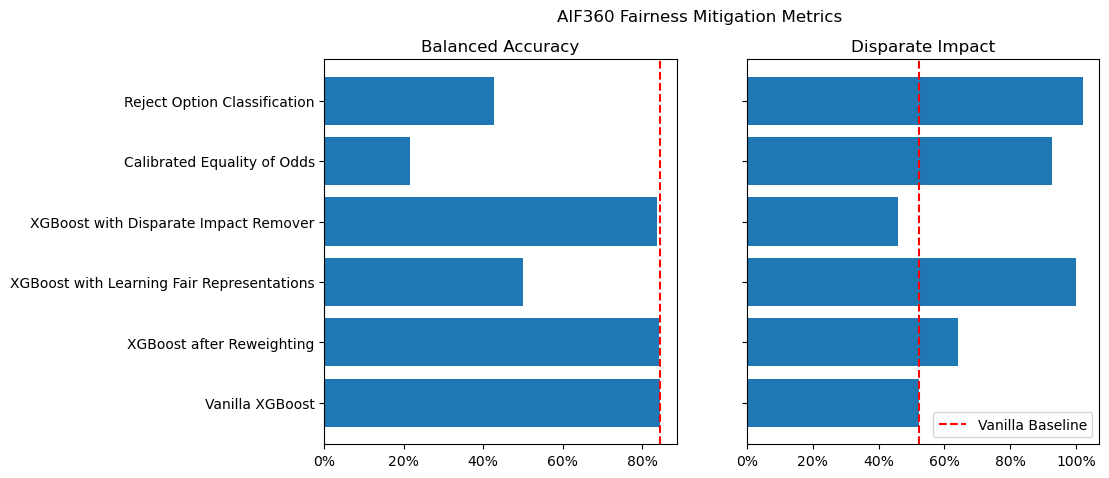

In [7]:


fig, axes = plt.subplots(1,2,figsize = (10,5), sharey = True)
axes[0].barh(np.arange(len(aif_compare["name"])), np.array(aif_compare["balanced accuracy"]) * 100)
axes[0].set_yticks(np.arange(len(aif_compare["name"])), labels=aif_compare["name"])
axes[0].axvline(x = aif_compare["balanced accuracy"][0] * 100, linestyle = "dashed", c = "red")
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].set_title("Balanced Accuracy")

axes[1].barh(np.arange(len(aif_compare["name"])), np.array(aif_compare["disparate impact"]) * 100)
axes[1].set_yticks(np.arange(len(aif_compare["name"])), labels=aif_compare["name"])
axes[1].axvline(x = aif_compare["disparate impact"][0] * 100, linestyle = "dashed", c = "red", label = "Vanilla Baseline")
axes[1].set_title("Disparate Impact")
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].legend()

fig.suptitle("AIF360 Fairness Mitigation Metrics")
plt.show()
